### import pacakges

In [1]:
import sys
print(sys.version, sys.platform, sys.executable)

3.10.13 (main, Nov 16 2023, 19:48:55) [GCC 9.4.0] linux /home/codespace/.python/current/bin/python3


In [2]:
from tqdm import tqdm

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import os
import sys
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable

from scipy.ndimage import rotate
from pretrained_models.resnet20 import ResNetCIFAR

from utils import *
from importlib import reload
reload(sys.modules['utils'])

2023-12-14 21:45:50.312358: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 21:45:50.312423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 21:45:50.313735: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 21:45:50.322469: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 21:45:51.517037: W tensorflow/compiler/tf2

<module 'utils' from '/workspaces/Adversarial-Patches-Experimentation/10_code/utils.py'>

# prepare data

In [4]:
# PARAMS
batch_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patch_size = 0.1
target = 1 #automobile

#CIFAR-10 image tensor mean and std
NORM_MEAN = [0.4914, 0.4822, 0.4465]
NORM_STD = [0.2023, 0.1994, 0.2010]


# TODO: should we apply the below transformations?
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

transform_image = transforms.ToPILImage()

print('==> Preparing data..')
trainset = torchvision.datasets.CIFAR10(root='../00_data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='../00_data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


### patch

In [5]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    """this function transforms the numbers in an image patch so that they match the expected range for an image,
    using special adjustments based on means and standard deviations (TENSOR_MEANS and TENSOR_STD)."""
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [6]:
def place_patch(img, patch):
    """This function takes an image batch (img) and a smaller image portion (patch), and
    randomly selects positions within each image in the batch and replaces a part of that image with the modified patch."""
    for i in range(img.shape[0]):
        # enerates random values (h_offset and w_offset) to determine where to place the patch within the img. 
        # ensures that the patch stays within the bounds of the img.
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        # takes a specific image img[i] from the batch and replaces a portion of it with the modified patch.
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

In [20]:
def eval_patch(model, patch, val_loader):
    """this function evaluate the performance of a neural network model when 
    presented with images containing a specific patch"""
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    n = 0 # number of images
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                #tp += torch.logical_and(pred.argmax(dim=-1) == img_labels).sum()
                tp += (pred.argmax(dim=-1) == img_labels).sum().item()
                #tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == img_labels).any(dim=-1)).sum()
                tp_5 += (pred.topk(5, dim=-1)[1] == img_labels.unsqueeze(1)).any(dim=-1).sum().item()
                counter += (img_labels).sum()
                n += (img_labels).sum()
    acc = tp/counter
    top5 = tp_5/counter
    attack_success_rate = tp/n
    return acc, top5, attack_success_rate

In [27]:
def patch_attack(model, patch_size=10, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(trainset, [0.8, 0.2])
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last = True, num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, img_labels in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = img_labels.to(device)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")
        if epoch % 1 == 0:
            acc, top5, atttack_success_rate = eval_patch(model, patch, val_loader)
            print(f"Epoch {epoch}, Attack Success Rate: {atttack_success_rate.item()}")

    # Final validation
    # acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item(), "attack_success_rate": atttack_success_rate.item()}


In [28]:
# load the Pre-Trained ResNet-20 model
net = ResNetCIFAR(num_layers=20, Nbits=None)
net = net.to(device)
net.load_state_dict(torch.load("./pretrained_models/pretrained_model.pt"))

<All keys matched successfully>

In [29]:
#Untargeted Attack
p, x = patch_attack(net, patch_size=5, num_epochs=30)

Epoch 0, Attack Success Rate: 0.1982094794511795


Epoch 1, Attack Success Rate: 0.19978967308998108


Epoch 2, Attack Success Rate: 0.19981749355793


Epoch 3, Attack Success Rate: 0.20011796057224274


Epoch 4, Attack Success Rate: 0.1998341828584671


Epoch 5, Attack Success Rate: 0.19950033724308014


Epoch 6, Attack Success Rate: 0.20007900893688202


Epoch 7, Attack Success Rate: 0.1996283233165741


Epoch 8, Attack Success Rate: 0.19906078279018402


Epoch 9, Attack Success Rate: 0.20015691220760345


Epoch 10, Attack Success Rate: 0.19987313449382782


Epoch 11, Attack Success Rate: 0.20036277174949646


Epoch 12, Attack Success Rate: 0.20017915964126587


Epoch 13, Attack Success Rate: 0.2006687968969345


Epoch 14, Attack Success Rate: 0.20056308805942535


Epoch 15, Attack Success Rate: 0.19970621168613434


Epoch 16, Attack Success Rate: 0.19951146841049194


Epoch 17, Attack Success Rate: 0.20037390291690826


Epoch 18, Attack Success Rate: 0.1994446963071823


Epoch 19, Attack Success Rate: 0.19998998939990997


Epoch 20, Attack Success Rate: 0.19991208612918854


Epoch 21, Attack Success Rate: 0.20100821554660797


Epoch 22, Attack Success Rate: 0.20015691220760345


Epoch 23, Attack Success Rate: 0.2008468508720398


Epoch 24, Attack Success Rate: 0.20060759782791138


Epoch 25, Attack Success Rate: 0.20055751502513885


Epoch 26, Attack Success Rate: 0.2010694146156311


Epoch 27, Attack Success Rate: 0.20080789923667908


Epoch 28, Attack Success Rate: 0.19976185262203217


Epoch 29, Attack Success Rate: 0.20029044151306152


In [30]:
def eval_patch(model, patch, val_loader, intensity_factor):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    n = 0 # number of images
    
    # Apply intensity modification to the patch
    modified_patch = patch * intensity_factor
    
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the modified patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, modified_patch)  # Use the modified patch
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                
                # Update accuracy metrics
                tp += (pred.argmax(dim=-1) == img_labels).sum().item()
                tp_5 += (pred.topk(5, dim=-1)[1] == img_labels.unsqueeze(1)).any(dim=-1).sum().item()
                counter += (img_labels).sum()
                n += (img_labels).sum()
    
    acc = tp / counter
    top5 = tp_5 / counter
    attack_success_rate = tp / n
    
    return acc, top5, attack_success_rate


In [34]:
def patch_attack(model, patch_size=10, num_epochs=5, intensity_factor =1):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(trainset, [0.8, 0.2])
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last = True, num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, img_labels in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = img_labels.to(device)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")
        if epoch % 5 == 0:
            acc, top5, atttack_success_rate = eval_patch(model, patch, val_loader, intensity_factor)
            print(f"Epoch {epoch}, Attack Success Rate: {atttack_success_rate.item()}")

    # Final validation
    # acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item(), "attack_success_rate": atttack_success_rate.item()}


In [35]:
intensity_factors = [0.5, 1.5, 2.0]  # Try different intensity factors
for factor in intensity_factors:
    print(f"intensity factor: {factor}")
    patch_attack(net, patch_size=5, num_epochs=30, intensity_factor=factor)
    print("----------------")

intensity factor: 0.5


Epoch 0, Attack Success Rate: 0.19604730606079102


Epoch 5, Attack Success Rate: 0.19820453226566315


Epoch 10, Attack Success Rate: 0.1974688619375229


Epoch 15, Attack Success Rate: 0.1985308825969696


Epoch 20, Attack Success Rate: 0.19882957637310028


Epoch 25, Attack Success Rate: 0.19834834337234497


----------------
intensity factor: 1.5


Epoch 0, Attack Success Rate: 0.1978716254234314


Epoch 5, Attack Success Rate: 0.19953995943069458


Epoch 8, Loss: 0.12:  86%|████████▌ | 134/156 [00:18<00:02,  7.70it/s]

In [45]:
#targeted results
p, x = patch_attack(net, target_class=8, patch_size=5, num_epochs=30)

Epoch 0, Attack Success Rate: 0.01


Epoch 5, Attack Success Rate: 0.12


Epoch 10, Attack Success Rate: 0.12


Epoch 15, Attack Success Rate: 0.12


Epoch 20, Attack Success Rate: 0.12


Epoch 25, Attack Success Rate: 0.13


In [24]:
# check test accuracy
eval_patch(net, p, testloader, target_class=8)

(tensor(0.0598, device='cuda:0'), tensor(0.4388, device='cuda:0'))

In [ ]:
# show patch
# plt.imshow(transform_image(patch_forward(p).cpu()))

In [26]:
p = (torch.tanh(p) + 1) / 2 # Parameter to pixel values
p = p.cpu().permute(1, 2, 0).numpy()
p = np.clip(p, a_min=0.0, a_max=1.0)

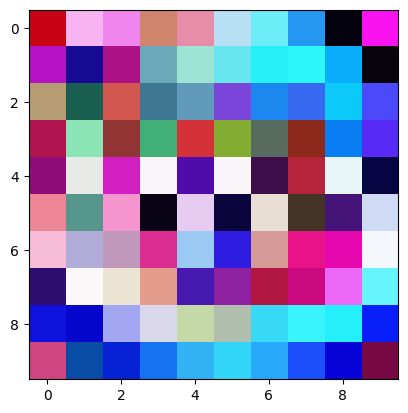

In [28]:
plt.imshow(p)